In [1]:
# Check GPU status
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Use same datasets as Model (2)
This model uses the same data as Model (2); however, instead of assigning sentiment labels as whole numbers (e.g., 0 = neutral, 1 = positive, -1 = negative), we aim to provide more detailed sentiment information by showing the probability of each class. For example, a piece of news might be classified as negative but not strongly negative (e.g., -0.2 instead of -0.9999), indicating it is only slightly negative. This approach gives us more granularity in the dataset. We use the softmax function to calculate these probabilities for each class.


In [2]:
!pip install transformers

In [3]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load  data
cleaned_data_path = "merged_news_nosentiment.csv"
cleaned_data = pd.read_csv(cleaned_data_path)

# Ensure titles are valid 
cleaned_data = cleaned_data[cleaned_data['title'].notnull()]  # Remove null rows
titles = cleaned_data['title'].astype(str).tolist()

# Load FinBERT model & tokenizer
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Enable GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU

# Classify entiment in batches & get probabilities
def classify_sentiment_batch(texts):
    try:
        inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad():  
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)  # Get probabilities with Softmax
            # Map to sentiment score: Neutral=0, Positive=1, Negative=-1
            scores = probs @ torch.tensor([0, 1, -1], dtype=torch.float32, device=device)
        return probs.cpu().tolist(), scores.cpu().tolist()
    except Exception as e:
        print(f"Error in batch processing: {e}")
        return [None] * len(texts), [None] * len(texts)  

# Process data in batches
batch_size = 64
all_probs = []
all_scores = []
retry_limit = 3  

print("Starting sentiment analysis...")
for i in range(0, len(titles), batch_size):
    batch = titles[i:i + batch_size]
    for attempt in range(retry_limit):
        batch_probs, batch_scores = classify_sentiment_batch(batch)
        if all(p is not None for p in batch_probs):
            all_probs.extend(batch_probs)
            all_scores.extend(batch_scores)
            break  
        elif attempt == retry_limit - 1:  
            print(f"Failed to process batch {i} to {i + batch_size} after {retry_limit} attempts.")
            all_probs.extend([[None, None, None]] * len(batch))  
            all_scores.extend([None] * len(batch))
    if (i // batch_size) % 10 == 0: 
        print(f"Processed {i} titles out of {len(titles)}")

# Add sentiment probabilities and scores to the Dataframe
cleaned_data = cleaned_data.iloc[:len(all_probs)] 
cleaned_data[['neutral_prob', 'positive_prob', 'negative_prob']] = pd.DataFrame(all_probs)
cleaned_data['sentiment_score'] = all_scores

# Check & report missing values
null_score_count = cleaned_data['sentiment_score'].isnull().sum()
if null_score_count > 0:
    print(f"Warning: {null_score_count} rows have null sentiment values.")

# Save the data
labeled_data_path = "labeled_reuters_data_with_probs.csv"
cleaned_data.to_csv(labeled_data_path, index=False)

print(f"Sentiment probabilities and scores added. Labeled data saved to {labeled_data_path}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Streaming output truncated to the last 5000 lines.
Processed 1749120 titles out of 4947985
Processed 1749760 titles out of 4947985
Processed 1750400 titles out of 4947985
Processed 1751040 titles out of 4947985
Processed 1751680 titles out of 4947985
Processed 1752320 titles out of 4947985
Processed 1752960 titles out of 4947985
Processed 1753600 titles out of 4947985
Processed 1754240 titles out of 4947985
Processed 1754880 titles out of 4947985
Processed 1755520 titles out of 4947985
Processed 1756160 titles out of 4947985
Processed 1756800 titles out of 4947985
Processed 1757440 titles out of 4947985
Processed 1758080 titles out of 4947985
Processed 1758720 titles out of 4947985
Processed 1759360 titles out of 4947985
Processed 1760000 titles out of 4947985
Processed 1760640 titles out of 4947985
Processed 1761280 titles out of 4947985
Processed 1761920 titles out of 4947985
Processed 1762560 titles out of 4947985
Processed 1763200 titles out of 4947985
Processed 1763840 titles out 

In [5]:
newlab_data = pd.read_csv("labeled_reuters_data_with_probs.csv")

In [7]:
newlab_data.head()

,ts,title,neutral_prob,positive_prob,negative_prob,sentiment_score
0,2020-07-17 00:00:00+00:00,Jim Cramer: A better way to invest in the Covi...,0.027839,0.972148,0.000013,0.972135
1,2020-07-17 00:00:00+00:00,Cramer's lightning round: I would own Teradyne,0.999453,0.000021,0.000526,-0.000505
2,2020-07-17 00:00:00+00:00,"Cramer's week ahead: Big week for earnings, ev...",0.997833,0.002134,0.000033,0.002101
3,2020-07-17 00:00:00+00:00,IQ Capital CEO Keith Bliss says tech and healt...,0.522736,0.471170,0.006094,0.465076
4,2020-07-16 00:00:00+00:00,Wall Street delivered the 'kind of pullback I'...,0.986839,0.002836,0.010325,-0.007489


In [8]:
newlab_data.shape

(4947985, 6)

In [9]:
print(newlab_data.isnull().sum())

ts                 0
title              0
neutral_prob       0
positive_prob      0
negative_prob      0
sentiment_score    0
dtype: int64


In [10]:
print(newlab_data.columns)

Index(['ts', 'title', 'neutral_prob', 'positive_prob', 'negative_prob',
       'sentiment_score'],
      dtype='object')


# Select only news related to AAPL (Apple Company)
We will use the BERT Sentence Transformer to filter news related to Apple, as we have decided to focus on one company for this project, and we have chosen Apple (AAPL).

In [11]:
pip install sentence-transformers

In [13]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import torch

# Load data set in chunk because it's a lot of data
chunk_size = 100000  
merged_news_data_path = "labeled_reuters_data_with_probs.csv"

# Load the Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Define Apple-related keywords 
keywords = [
    'Apple',
    'iPhone',
    'MacBook',
    'iPad',
    'Apple revenue',
    'Apple earnings',
    'Apple product',
    'Apple stock',
    'smartphone',
    'mobile phone',
    'laptop',
    'computer',
    'samsung',
    'phone',
    'mobile',
    'Nokia',
    'gadget',
    'ios',
    'telecommunication',
    'Tim Cook',
    'Technology'
]

# Create a regex to ensure exact matches
keywords_regex = r'\b(?:' + '|'.join(keywords) + r')\b'

filtered_rows = []

# Process the dataset 
for chunk in pd.read_csv(merged_news_data_path, chunksize=chunk_size):
    # Pre-filter using keywords with exact matches
    keyword_filtered = chunk[chunk['title'].str.contains(keywords_regex, case=False, na=False, regex=True)]

    # Generate embeddings for the filtered titles
    titles = keyword_filtered['title'].dropna().tolist()
    embeddings = model.encode(titles, convert_to_tensor=True)

    # Generate embeddings for the queries
    query_embeddings = model.encode(keywords, convert_to_tensor=True)

    # Compute cosine similarities & take max score for each title
    cosine_scores = torch.max(util.cos_sim(query_embeddings, embeddings), dim=0)[0]

    # Filter by similarity threshold
    threshold = 0.2
    indices = [i for i, score in enumerate(cosine_scores) if score > threshold]

    # Append matching rows to the filtered list
    filtered_rows.append(keyword_filtered.iloc[indices])

# Combine all filtered rows into a 1 Dataframe
filtered_data = pd.concat(filtered_rows, ignore_index=True)

# Save data
filtered_data.to_csv("filtered_apple_news.csv", index=False)
print(f"Filtered dataset saved with {len(filtered_data)} rows.")

Filtered dataset saved with 93313 rows.


In [14]:
# Show a sample of the filtered data
filtered_data.head()

,ts,title,neutral_prob,positive_prob,negative_prob,sentiment_score
0,2020-06-30 00:00:00+00:00,Cramer's lightning round: Nokia has 'good thin...,5.152726e-08,9.999998e-01,1.299233e-07,1.000000
1,2020-03-03 00:00:00+00:00,Charts show the S&P's bounce may be 'ephemeral...,7.243818e-04,9.992748e-01,7.890475e-07,0.999274
2,2020-02-19 00:00:00+00:00,"Everything Jim Cramer said on 'Mad Money,' inc...",9.999844e-01,1.933114e-07,1.532001e-05,-0.000015
3,2020-02-18 00:00:00+00:00,Bank stocks were the 'worst performers' after ...,9.947161e-06,6.849663e-06,9.999833e-01,-0.999976
4,2020-01-30 00:00:00+00:00,"Everything Jim Cramer said on 'Mad Money,' inc...",9.999918e-01,4.188167e-07,7.794953e-06,-0.000007


In [15]:
print(f"Merged news date range: {filtered_data['ts'].min()} to {filtered_data['ts'].max()}")

Merged news date range: 2009-11-16 00:00:00+00:00 to 2020-07-16 00:00:00+00:00


In [16]:
filtered_data.shape

(93313, 6)

In [17]:
# Check unique day
filtered_data['ts'] = pd.to_datetime(filtered_data['ts'])

filtered_data['date_only'] = filtered_data['ts'].dt.date

unique_dates_count = filtered_data['date_only'].nunique()

print(f"Number of unique dates in filtered_data: {unique_dates_count}")

Number of unique dates in filtered_data: 2762


In [18]:
# Just checking by filter rows for the specific date (2009-11-16)
specific_date_news = filtered_data[filtered_data['ts'].dt.date == pd.to_datetime("2009-11-16").date()]

# Display all rows for the specific date
print(specific_date_news)

                            ts  \
1069 2009-11-16 21:05:00+00:00   
1070 2009-11-16 20:00:00+00:00   
1071 2009-11-16 19:51:00+00:00   
1072 2009-11-16 18:44:00+00:00   
1073 2009-11-16 18:17:00+00:00   
...                        ...   
1140 2009-11-16 02:00:00+00:00   
1141 2009-11-16 01:52:00+00:00   
1142 2009-11-16 01:00:00+00:00   
1143 2009-11-16 00:09:00+00:00   
1144 2009-11-16 00:00:00+00:00   

                                                  title  neutral_prob  \
1069  Convey Computer Corporation Honored with HPCwi...  7.470935e-05   
1070  GSMA Shines Spotlight on Asian Mobile Industry...  6.996329e-01   
1071          Does It Make Sense for Nokia to Buy Palm?  9.991828e-01   
1072  Immersion Presenting at Mobile User Experience...  9.999884e-01   
1073  Reaching the Hard-to-Reach:How Text Messaging ...  9.995648e-01   
...                                                 ...           ...   
1140  Stratos Expands its MobileLink Fixed-to-Mobile...  1.477139e-01   
1141  C

# Fetch Stock Price Data
Then we add stock price (AAPL) from yahoo finance.

In [67]:
pip install yfinance

In [68]:
import yfinance as yf

stock_data = yf.download('AAPL', start='2009-11-15', end='2020-07-17', interval='1d')

stock_data.reset_index(inplace=True)

stock_data_path = "aapl_stock_data.csv"
stock_data.to_csv(stock_data_path, index=False)

print("Stock data saved. Here's a preview:")
stock_data.head()

[*********************100%***********************]  1 of 1 completed

Stock data saved. Here's a preview:


Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
0,2009-11-16 00:00:00+00:00,6.225077,7.379643,7.428571,7.321786,7.338571,485206400
1,2009-11-17 00:00:00+00:00,6.236223,7.392857,7.408571,7.321429,7.360000,396513600
2,2009-11-18 00:00:00+00:00,6.204890,7.355714,7.392857,7.285714,7.376429,374320800
3,2009-11-19 00:00:00+00:00,6.040701,7.161071,7.307500,7.135714,7.307500,542326400
4,2009-11-20 00:00:00+00:00,6.022928,7.140000,7.156786,7.062857,7.112500,406666400


# Align News Sentiment with Stock Prices
We will merge the filtered news data (related to Apple) with stock price data into a single file. After merging, we will calculate the following features:

- Average sentiment score for each day (to summarize sentiment when there are multiple news articles in a day).

- Average sentiment score for each class probabilities (e.g., average positive probabilities, average negative probabilites) to provide a detailed breakdown of sentiment.

- Variance of sentiment scores for each day (to capture sentiment variability).

- Count of positive and negative news articles for each day (to measure the sentiment distribution).

Finally, we will create the target variable based on the actual stock closing price as follows:

- 0 (neutral): If today's closing price is the same as yesterday's closing price.

- 1 (positive): If today's closing price is higher than yesterday's closing price.

- 2 (negative): If today's closing price is lower than yesterday's closing price.

This approach will provide a deeper dataset for analyzing the relationship between news sentiment and stock price movements.

In [69]:
import numpy as np
import pandas as pd

# Load filtered news data & stock price data
labeled_data = pd.read_csv("filtered_apple_news.csv")
stock_data = pd.read_csv("aapl_stock_data.csv")

# Convert timestamps to datetime
labeled_data['ts'] = pd.to_datetime(labeled_data['ts'])
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Remove timezone from stock data
stock_data['Date'] = stock_data['Date'].dt.tz_localize(None)

# Extract day from timestamp for grouping
labeled_data['day'] = labeled_data['ts'].dt.date

# Define a threshold (epsilon) for "Neutral" sentiment
epsilon = 0.01  # Adjust this threshold as needed

# Compute daily aggregated sentiment features
daily_sentiment = labeled_data.groupby('day').agg(
    avg_sentiment=('sentiment_score', 'mean'),  # Avg sentiment 
    variance=('sentiment_score', 'var'),       # Variance of sentiment 
    avg_positive_prob=('positive_prob', 'mean'),  # Avg positive probability
    avg_negative_prob=('negative_prob', 'mean'),  # Avg negative probability
    pos_count=('sentiment_score', lambda x: (x > epsilon).sum()),  # Positive count
    neg_count=('sentiment_score', lambda x: (x < -epsilon).sum())  # Negative count
).reset_index()

# Rename & ensure 'Date' is in datetime format
daily_sentiment.rename(columns={'day': 'Date'}, inplace=True)
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])

# Debugging: Check daily sentiment features
print("Daily Sentiment Features:")
print(daily_sentiment.head())

# Align daily sentiment features with stock data
aligned_data = pd.merge(stock_data, daily_sentiment, on='Date', how='left')

# Ensure numeric columns in stock data are properly converted to float
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
aligned_data[numeric_cols] = aligned_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Drop missing rows
aligned_data.dropna(subset=numeric_cols, inplace=True)

# Fill missing sentiment values with rolling average
aligned_data[['avg_sentiment', 'variance', 'avg_positive_prob', 'avg_negative_prob', 'pos_count', 'neg_count']] = aligned_data[[
    'avg_sentiment', 'variance', 'avg_positive_prob', 'avg_negative_prob', 'pos_count', 'neg_count']].fillna(
    aligned_data[['avg_sentiment', 'variance', 'avg_positive_prob', 'avg_negative_prob', 'pos_count', 'neg_count']].rolling(window=3, min_periods=1).mean()
).fillna(0)  # Fill remaining NaNs with 0

# Define thresholds for classifying "Neutral" movement
threshold = 0.01

# Create the multi-class target variable
aligned_data['target'] = np.where(
    (aligned_data['Close'].shift(-1) - aligned_data['Close']) > threshold,  
    1,  # Class 1: Increase
    np.where(
        (aligned_data['Close'].shift(-1) - aligned_data['Close']) < -threshold, 
        2,  # Class 2: Decrease
        0  # Class 0: Neutral
    )
)

# Drop rows with NaN target (last row won't have a target)
aligned_data = aligned_data.dropna(subset=['target'])
aligned_data['target'] = aligned_data['target'].astype(int)  

# Save data
aligned_data.to_csv("aligned_data_with_features.csv", index=False)

# Debugging & validation
print("Aligned dataset saved with additional features. Here's a preview:")
print(aligned_data[['Date', 'avg_sentiment', 'variance', 'avg_positive_prob', 'avg_negative_prob', 'pos_count', 'neg_count', 'target']].head())

# Check class distribution
print("\nClass Distribution in Target Variable:")
print(aligned_data['target'].value_counts())

print("\nAligned Data Shape:", aligned_data.shape)

Daily Sentiment Features:
        Date  avg_sentiment  variance  avg_positive_prob  avg_negative_prob  \
0 2009-11-16       0.241275  0.216212           0.268320           0.027045   
1 2009-11-17       0.183195  0.165757           0.198665           0.015471   
2 2009-11-18       0.206703  0.204869           0.243879           0.037176   
3 2009-11-19       0.168360  0.212191           0.213120           0.044759   
4 2009-11-20       0.122495  0.295882           0.229943           0.107448   

   pos_count  neg_count  
0         31          2  
1         18          2  
2         28          4  
3         21          5  
4          9          5  
Aligned dataset saved with additional features. Here's a preview:
        Date  avg_sentiment  variance  avg_positive_prob  avg_negative_prob  \
1 2009-11-16       0.241275  0.216212           0.268320           0.027045   
2 2009-11-17       0.183195  0.165757           0.198665           0.015471   
3 2009-11-18       0.206703  0.204869   

In [70]:
aligned_data.head()

,Date,Adj Close,Close,High,Low,Open,Volume,avg_sentiment,variance,avg_positive_prob,avg_negative_prob,pos_count,neg_count,target
1,2009-11-16,6.225077,7.379643,7.428571,7.321786,7.338571,485206400.0,0.241275,0.216212,0.268320,0.027045,31.0,2.0,1
2,2009-11-17,6.236223,7.392857,7.408571,7.321429,7.360000,396513600.0,0.183195,0.165757,0.198665,0.015471,18.0,2.0,2
3,2009-11-18,6.204890,7.355714,7.392857,7.285714,7.376429,374320800.0,0.206703,0.204869,0.243879,0.037176,28.0,4.0,2
4,2009-11-19,6.040701,7.161071,7.307500,7.135714,7.307500,542326400.0,0.168360,0.212191,0.213120,0.044759,21.0,5.0,2
5,2009-11-20,6.022928,7.140000,7.156786,7.062857,7.112500,406666400.0,0.122495,0.295882,0.229943,0.107448,9.0,5.0,1


In [71]:
print(f"Filtered news date range: {labeled_data['ts'].min()} to {labeled_data['ts'].max()}")
print(f"Stock data date range: {stock_data['Date'].min()} to {stock_data['Date'].max()}")

Filtered news date range: 2009-11-16 00:00:00+00:00 to 2020-07-16 00:00:00+00:00
Stock data date range: 2009-11-16 00:00:00 to 2020-07-16 00:00:00


In [72]:
aligned_data.shape

(2684, 14)

In [73]:
aligned_data.isnull().sum()

,0
Date,0
Adj Close,0
Close,0
High,0
Low,0
Open,0
Volume,0
avg_sentiment,0
variance,0
avg_positive_prob,0


In [75]:
# Count positive and negative numbers in avg_sentiment column
positive_count = (aligned_data['avg_sentiment'] > 0).sum()
negative_count = (aligned_data['avg_sentiment'] < 0).sum()

# Print the results
print(f"Number of positive avg_sentiment values: {positive_count}")
print(f"Number of negative avg_sentiment values: {negative_count}")

Number of positive avg_sentiment values: 1770
Number of negative avg_sentiment values: 518


# Split the data
Training Set: 2009-11-16 to 2018-12-01 (~80% of the data)

Validation Set: 2018-12-02 to 2019-09-30 (~10% of the data)

Testing Set: 2019-10-01 to 2020-07-16 (~10% of the data).

In [214]:
import pandas as pd

# Load aligned dataset
aligned_data_path = "aligned_data_with_features.csv"
aligned_data = pd.read_csv(aligned_data_path)

aligned_data['Date'] = pd.to_datetime(aligned_data['Date'])

# Split data chronologically
train_data = aligned_data[aligned_data['Date'] < '2018-12-01']
val_data = aligned_data[(aligned_data['Date'] >= '2018-12-02') & (aligned_data['Date'] < '2019-09-30')]
test_data = aligned_data[aligned_data['Date'] >= '2019-10-01']

print(f"Training set: {len(train_data)} rows")
print(f"Validation set: {len(val_data)} rows")
print(f"Testing set: {len(test_data)} rows")

# Save data
train_data.to_csv("train_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

Training set: 2277 rows
Validation set: 206 rows
Testing set: 200 rows


In [196]:
print("Train data columns:", train_data.columns)
print("Validation data columns:", val_data.columns)
print("Test data columns:", test_data.columns)

Train data columns: Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'avg_sentiment', 'variance', 'avg_positive_prob', 'avg_negative_prob',
       'pos_count', 'neg_count', 'target'],
      dtype='object')
Validation data columns: Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'avg_sentiment', 'variance', 'avg_positive_prob', 'avg_negative_prob',
       'pos_count', 'neg_count', 'target'],
      dtype='object')
Test data columns: Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'avg_sentiment', 'variance', 'avg_positive_prob', 'avg_negative_prob',
       'pos_count', 'neg_count', 'target'],
      dtype='object')


In [197]:
# Count class distribution in train, validation, and test datasets
print("Class distribution in training set:")
print(train_data['target'].value_counts())

print("\nClass distribution in validation set:")
print(val_data['target'].value_counts())

print("\nClass distribution in testing set:")
print(test_data['target'].value_counts())

Class distribution in training set:
target
1    1156
2    1043
0      78
Name: count, dtype: int64

Class distribution in validation set:
target
1    109
2     93
0      4
Name: count, dtype: int64

Class distribution in testing set:
target
1    114
2     83
0      3
Name: count, dtype: int64


In [230]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Features & target
features = ['avg_sentiment', 'Open', 'High', 'Low', 'Close', 'Volume','variance', 'pos_count', 'neg_count','avg_positive_prob', 'avg_negative_prob']
target = 'target'

# Scale features
scaler = MinMaxScaler()
train_features = scaler.fit_transform(train_data[features])
val_features = scaler.transform(val_data[features])
test_features = scaler.transform(test_data[features])

# Create sequences
def create_sequences(data, labels, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(labels[i + seq_length])
    return np.array(X), np.array(y)

# Sequence length
sequence_length = 20

# Create sequences for training, validation, and testing
X_train, y_train = create_sequences(train_features, train_data[target].values, sequence_length)
X_val, y_val = create_sequences(val_features, val_data[target].values, sequence_length)
X_test, y_test = create_sequences(test_features, test_data[target].values, sequence_length)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

Training set: (2257, 20, 11), (2257,)
Validation set: (186, 20, 11), (186,)
Testing set: (180, 20, 11), (180,)


In [231]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Define LSTM model
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        #self.dropout = nn.Dropout(0.05)  # Dropout after LSTM
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use last time step
        return out

# Model parameters
input_size = X_train.shape[2]
hidden_size = 32
num_layers = 2
output_size = 3  # Model Classification: 0, 1, 2

model = StockLSTM(input_size, hidden_size, num_layers, output_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop with validation
epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/100, Training Loss: 37.9150, Validation Loss: 2.8063
Epoch 2/100, Training Loss: 30.6631, Validation Loss: 2.3366
Epoch 3/100, Training Loss: 29.3395, Validation Loss: 2.3378
Epoch 4/100, Training Loss: 29.4034, Validation Loss: 2.3408
Epoch 5/100, Training Loss: 29.4256, Validation Loss: 2.3451
Epoch 6/100, Training Loss: 29.3916, Validation Loss: 2.3446
Epoch 7/100, Training Loss: 29.2603, Validation Loss: 2.3407
Epoch 8/100, Training Loss: 29.4911, Validation Loss: 2.3359
Epoch 9/100, Training Loss: 29.4222, Validation Loss: 2.3428
Epoch 10/100, Training Loss: 29.4173, Validation Loss: 2.3379
Epoch 11/100, Training Loss: 29.2601, Validation Loss: 2.3461
Epoch 12/100, Training Loss: 29.3817, Validation Loss: 2.3521
Epoch 13/100, Training Loss: 29.2439, Validation Loss: 2.3558
Epoch 14/100, Training Loss: 29.4063, Validation Loss: 2.3496
Epoch 15/100, Training Loss: 29.2576, Validation Loss: 2.3488
Epoch 16/100, Training Loss: 29.2566, Validation Loss: 2.3509
Epoch 17/100, Tra

In [232]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate on test data
test_loader = DataLoader(test_dataset, batch_size=64)
model.eval()
y_pred, y_true = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        output = model(X_batch)
        predictions = torch.argmax(output, dim=1)
        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

# Classification metrics
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Neutral', 'Positive', 'Negative']))

Confusion Matrix:
[[ 0  2  1]
 [ 0 67 34]
 [ 0 48 28]]

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00         3
    Positive       0.57      0.66      0.61       101
    Negative       0.44      0.37      0.40        76

    accuracy                           0.53       180
   macro avg       0.34      0.34      0.34       180
weighted avg       0.51      0.53      0.52       180



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Visualization

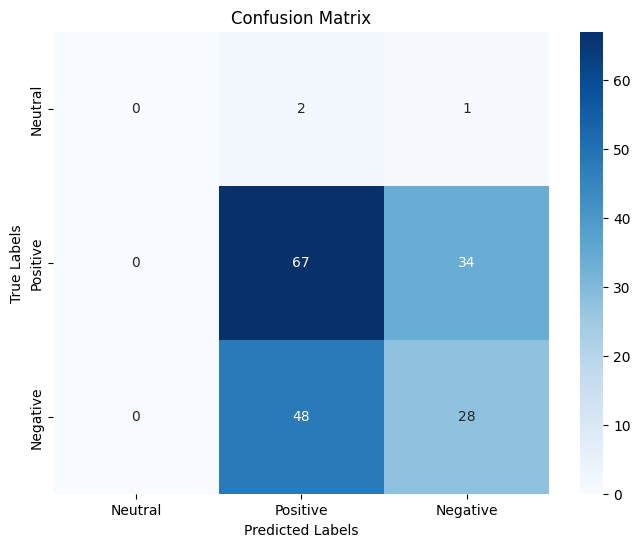

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Define class names
class_names = ['Neutral', 'Positive', 'Negative']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

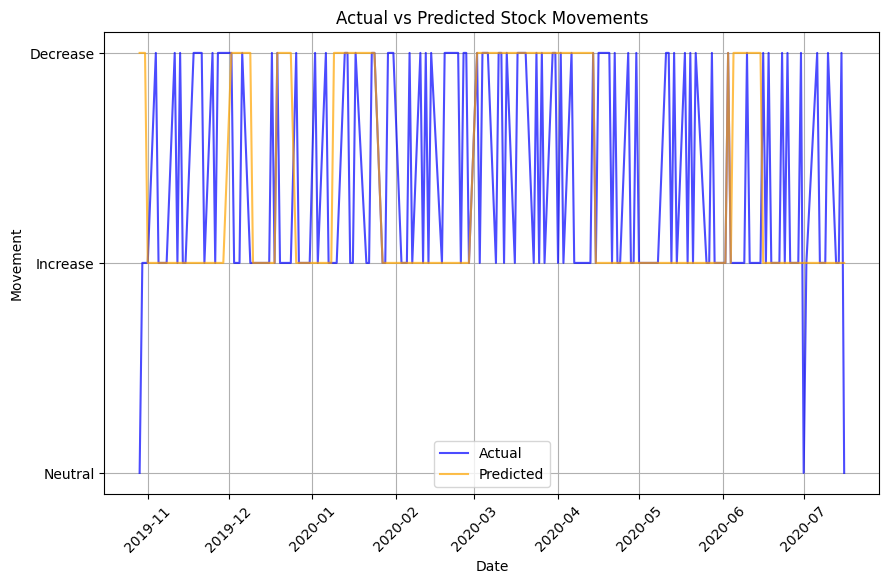

In [234]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot actual vs predicted class distributions
results_df = pd.DataFrame({
    'Actual': y_true,
    'Predicted': y_pred,
    'Date': test_data['Date'][sequence_length:]  
})

class_labels = {0: 'Neutral', 1: 'Increase', 2: 'Decrease'}
results_df['Actual'] = results_df['Actual'].map(class_labels)
results_df['Predicted'] = results_df['Predicted'].map(class_labels)

plt.figure(figsize=(10, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual', color='blue', alpha=0.7)
plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted', color='orange', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted Stock Movements')
plt.xlabel('Date')
plt.ylabel('Movement')
plt.xticks(rotation=45)
plt.grid()
plt.show()

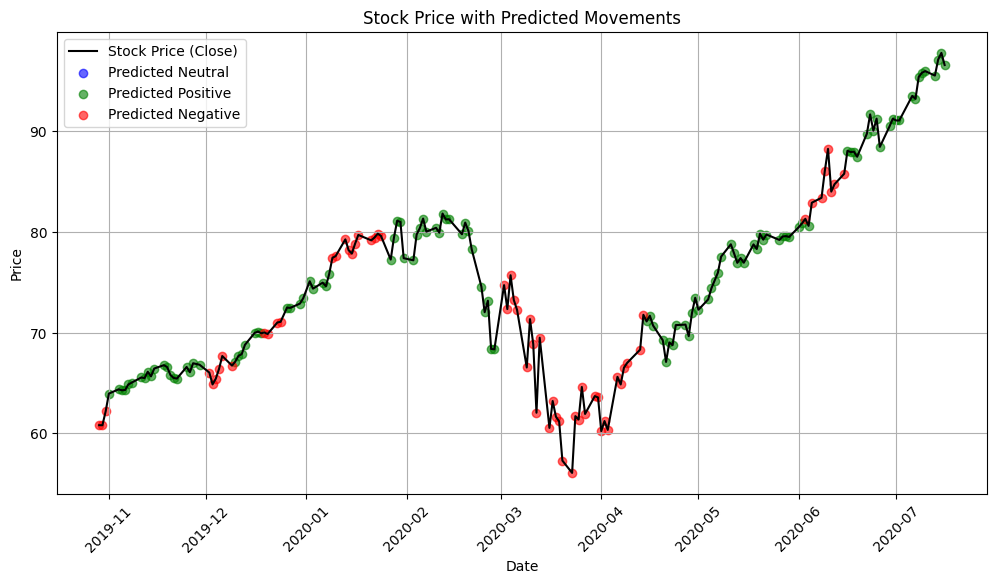

In [235]:
# Add the prediction to the stock data for visualization
aligned_test_data = test_data[sequence_length:].copy()
aligned_test_data['Predicted'] = y_pred

# Plot stock price and predictions
plt.figure(figsize=(12, 6))
plt.plot(aligned_test_data['Date'], aligned_test_data['Close'], label='Stock Price (Close)', color='black')

plt.scatter(aligned_test_data['Date'][aligned_test_data['Predicted'] == 0],
            aligned_test_data['Close'][aligned_test_data['Predicted'] == 0],
            color='blue', label='Predicted Neutral', alpha=0.6)
plt.scatter(aligned_test_data['Date'][aligned_test_data['Predicted'] == 1],
            aligned_test_data['Close'][aligned_test_data['Predicted'] == 1],
            color='green', label='Predicted Positive', alpha=0.6)
plt.scatter(aligned_test_data['Date'][aligned_test_data['Predicted'] == 2],
            aligned_test_data['Close'][aligned_test_data['Predicted'] == 2],
            color='red', label='Predicted Negative', alpha=0.6)

plt.legend()
plt.title('Stock Price with Predicted Movements')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid()
plt.show()